In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# Hyperparameters
num_epochs = 4
batch_size = 4
learning_rate = 0.001

# One value for each channel
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

In [4]:
composed_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

### Loading data

**. =>** refers in the same folder

In [5]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=composed_transforms
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=False,
    transform=composed_transforms
)

Files already downloaded and verified


### Dataloaders

In [6]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

### Visualizing data

In [7]:
print("No. of Iterations/No. of batches =", len(train_loader))
print(type(train_loader))

dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape) # Batch_size=4, 4 samples are available

No. of Iterations/No. of batches = 12500
<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([4, 3, 32, 32]) torch.Size([4])


In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

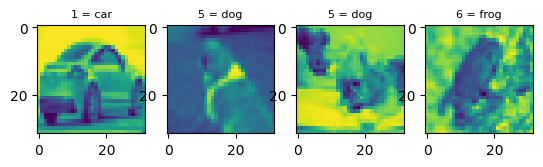

In [9]:
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i][0])
    item = labels[i].item()
    plt.title(f"{item} = {classes[item]}", fontsize=8)
plt.show()

### ConvNet model
- **in_channels** = No. of channels in input images(3)
- **out_channels** = No.of filters used/ No. of feature maps preoduced
- **kernel_size** = size of the filter or kernel used for the convolution

In [10]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # After passing through last conv+pool layer,
        # Input size => (4, 16, 5, 5) where 4 is no. of samples
        self.fc1 = nn.Linear(in_features=16*5*5, out_features = 120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.pool(out)
        out = F.relu(self.conv2(out))
        out = self.pool(out)


        # Flattening the layer
        out = out.reshape(-1, 16 * 5 * 5)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

### Model Training

Here no need to reshape images because the format in which ConvNet expects input is the default shape

- Original x shape = torch.Size([4, 3, 32, 32])
- After passing through 1st Conv layer, x shape = torch.Size([4, 6, 28, 28])
- After passing through 1st Pool layer, x shape = torch.Size([4, 6, 14, 14])
- After passing through 2nd Conv layer, x shape = torch.Size([4, 16, 10, 10])
- After passing through 2nd Pool layer, x shape = torch.Size([4, 16, 5, 5])

In [11]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

num_batches = len(train_loader)

for epoch in range(1, num_epochs+1):
    print("New Epoch starts!!!!!")
    for batch, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Fwd Propagation
        predicted = model(images)
        # print(labels.shape, predicted.shape)
        loss = criterion(predicted, labels)

        # Backward prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch+1)%5000==0:
            print(f"Epoch {epoch}/{num_epochs} Batch {batch+1}/{num_batches}, Loss = {loss.item():.4f}")
    print("#"*100)

New Epoch starts!!!!!
Epoch 1/4 Batch 5000/12500, Loss = 1.4706
Epoch 1/4 Batch 10000/12500, Loss = 0.9254
####################################################################################################
New Epoch starts!!!!!
Epoch 2/4 Batch 5000/12500, Loss = 0.6278
Epoch 2/4 Batch 10000/12500, Loss = 1.4408
####################################################################################################
New Epoch starts!!!!!
Epoch 3/4 Batch 5000/12500, Loss = 1.0930
Epoch 3/4 Batch 10000/12500, Loss = 1.0420
####################################################################################################
New Epoch starts!!!!!
Epoch 4/4 Batch 5000/12500, Loss = 2.7393
Epoch 4/4 Batch 10000/12500, Loss = 0.6005
####################################################################################################


### Model Evaluation

In [12]:
# Contains no. of correct sample for each class in test set
n_class_correct = [0 for i in range(10)]

# Contains total no. of samples for each class in test set
n_class_samples = [0 for i in range(10)]

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for (images, labels) in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        _, predicted = torch.max(output, dim=1)
        n_samples += labels.shape[0]
        n_correct += (predicted==labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if label==pred:
                n_class_correct[label]+=1
            n_class_samples[label]+=1
    accuracy = 100.0 * n_correct / n_samples
    print("Test Accuracy = ", accuracy, "%")

    for i in range(10):
        accuracy = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f"Test Accuracy of class{i}= {accuracy}%")

Test Accuracy =  60.79 %
Test Accuracy of class0= 64.6%
Test Accuracy of class1= 73.5%
Test Accuracy of class2= 44.1%
Test Accuracy of class3= 43.4%
Test Accuracy of class4= 53.5%
Test Accuracy of class5= 48.7%
Test Accuracy of class6= 66.5%
Test Accuracy of class7= 74.3%
Test Accuracy of class8= 70.4%
Test Accuracy of class9= 68.9%
